# Connecting to the Device

In [1]:
# Connect to the device
import belay
device = belay.Device("COM7")

In [2]:
# Command Codes
GET_DISTANCE = 0x02
STOP_GET_DISTANCE = 0x0F
GET_CORRECTION_PARAMS = 0x12
CONFIG_ADDRESS = 0x16
ACK = 0x10

In [3]:
def packetsToint(input : list) -> int:
    noPackets = len(input)
    runningSum = 0
    for packetIndex in range(noPackets, 0, -1):
        runningSum = (runningSum) * 256 + input[packetIndex-1]
    return runningSum

@device.task
def devicePacketsToint(input : list) -> int:
    noPackets = len(input)
    runningSum = 0
    for packetIndex in range(noPackets, 0, -1):
        runningSum = (runningSum) * 256 + input[packetIndex-1]
    return runningSum

def byteArryToHex(arry):
    return ' '.join('{:02x}'.format(x) for x in arry)
    
def intTo2Packets(inputVal : int) -> list:
    lsb = inputVal % 256
    msb = int(inputVal / 256)
    return [lsb, msb]

def calChecksum(body : list) -> int:
    checksum = 0
    for chunk in body:
        checksum += chunk
    return checksum % 256

def shortLidar(commandCode : int, data: list = []):
    startChars = [0xAA,0xAA,0xAA,0xAA]
    deviceId = 0x01
    packetOffset = [0x00, 0x00]
    dataLenth = intTo2Packets( len(data) )
    body = [deviceId, commandCode] + packetOffset + dataLenth + data
    checksum = calChecksum(body)
    msg = startChars + body + [checksum]
    retVal = sendLidarMsg(msg)
    return retVal

@device.task
def sendLidarMsg(msg : list):
    import machine
    from time import sleep
    uartPort = 0
    uartSpeed = 921600
    uart = machine.UART(uartPort, uartSpeed)
    uart.write(bytearray(msg))
    sleep(0.1)
    retVal = retrieveLidarMsg(uart)
    return retVal

@device.task
def retrieveLidarMsg(uart, retryUntilAA = True) -> bytearray:
    from time import sleep
    preData = b""
    if retryUntilAA:
        aCount = 0
        retryCount = 0
        while aCount < 4:
            charRead = uart.read(1)
            sleep(0.01)
            if charRead == b"\xaa":
                aCount += 1
            else:
                retryCount += 1
                aCount = 0
            assert retryCount < 500, f"Count not find start of the string aa 4 times, retried {retryCount} times"
        preData += b"\xaa\xaa\xaa\xaa"
    preData += uart.read(6)
    dataLen = devicePacketsToint(preData[-2:])
    data = b""
    while len(data) < dataLen:
        lenToRead = dataLen + 1 - len(data)
        newData = uart.read(lenToRead)
        if newData:
            data += newData
        else:
            sleep(0.05)
    assert dataLen+1 == len(data), f"Incorrect amount of data received.\r\nExpected {dataLen+1}\r\nReceived {len(data)}"
    return preData + data
    pass


In [4]:
# Test code to make sure that the commands work
retVal = shortLidar(GET_CORRECTION_PARAMS)
print(retVal)

b'\xaa\xaa\xaa\xaa\x00\x12\x00\x00\x12\x00\x8c\x00\x00\x00\x8c\x00\x00\x00(\x17\x00\x00\xd0\x14\x00\x00P\x00\xaf'


# Calibration

In [5]:
retVal = shortLidar(GET_CORRECTION_PARAMS)
print(f"returned Value: {byteArryToHex(retVal)}")
k0 = packetsToint(retVal[10:14]) / 10000.0
print(f"k0: {k0}")
k1 = packetsToint(retVal[14:18]) / 10000.0
print(f"k1: {k1}")
b0 = packetsToint(retVal[18:22]) / 10000.0
print(f"b0: {b0}")
b1 = packetsToint(retVal[22:26]) / 10000.0
print(f"b1: {b1}")


returned Value: aa aa aa aa 00 12 00 00 12 00 8c 00 00 00 8c 00 00 00 28 17 00 00 d0 14 00 00 50 00 af
k0: 0.014
k1: 0.014
b0: 0.5928
b1: 0.5328


## Message Sent: 
```python
ld07_getCorrectionData = [0xAA,0xAA,0xAA,0xAA,0x01,0x12,0x00,0x00,0x00,0x00,0x13]
```

|Characters | Description |
|---:|:---|
| 0xAA,0xAA,0xAA,0xAA, | Start Characters |
| 0x01, | Device Address 1 |
| 0x12, | Command Code - Get Correction Parameters |
| 0x00,0x00, | Packet Offset 0 |
| 0x00,0x00, | Data Length 0 |
|            | Data: None |
| 0x13 | Checksum (0x01 + 0x12) |

## Return Value:
```python
b'\xaa\xaa\xaa\xaa\x00\x12\x00\x00\x12\x00\x8c\x00\x00\x00\x8c\x00\x00\x00(\x17\x00\x00\xd0\x14\x00\x00P\x00\xaf'
```

|Characters | Description |
|---:|:---|
| \xaa\xaa\xaa\xaa | Start Characters |
| \x00 | Device Address 0 |
| \x12 | Command Code - Get Correction Parameters |
| \x00\x00 | Packet Offset 0 |
| \x12\x00 | Data Length 18 bits |
|  <br /> \x8c\x00\x00\x00 <br /> \x8c\x00\x00\x00 <br /> \x28\x17\x00\x00 <br /> \xd0\x14\x00\x00 <br /> \50\x00 | Data <br /> coe_k[0] = 140 <br /> coe_k[1] = 140 <br /> coe_b[0] = 5928 <br /> coe_b[1] = 5328 <br /> Points = 80 |
| \xaf | Checksum = 175 > 0xAF Hex |


## Converted to a coefficient used in distance calculations: 
``` C
 double k0 = (double)coe_k[0]/10000 = 0.0140； 
 double k1 = (double)coe_k[1]/10000 = 0.0140； 
 double b0 = (double)coe_b[0]/10000 = 0.5928； 
 double b1 = (double)coe_b[1]/10000 = 0.5328；
```

## Explanation
K0 and B0 are the distance calculation parameters of left camera;  
K1 and B1 are the distance calculation parameters of right camera;  
80 is the number of distance data points measured by a single camera, indicating totally 160 data points in the two cameras. 

# Get the distance data

In [11]:
retVal = b'\xaa\xaa\xaa\xaa\x00\x10\x00\x00\x02\x00\x0f\x01"'
# Note: The initial command gets an ACK message, so I'm just sending it over and over
# In the final code I should just be able to read the distance
while retVal[5] == 16:
    retVal = shortLidar(GET_DISTANCE)
num = byteArryToHex(retVal)
print(retVal)

b'\xaa\xaa\xaa\xaa\x00\x02\x00\x00D\x01\xb4\xe0\x00\x00\x00\x08\x00\x08\x00\n\x00\n\x00\x0c\x00\x0c\x00\x0c\x00\x0e\x00\x0e\x00\x0e\x00\x12\x00\x12\x00\x12\x00\x12\x00\x10\x00\x10\x00\x0e\x00\n\x00\n\x00\n\x00\n\x00\n\x00\n\x00\n\x00\n\x00\n\x00\x0c\x00\x0c\x00\x0c\x00\x0c\x00\x0e\x00\x10\x00\x12\x9e\x1a\xa3(\xa5h\xa2\xd2\xa8\xba\xa6P\xa9:\xac(\xac\x1a\x00\x14\x00\x12\x00\x12\x00\x10\x00\x0e\x00\x0c\x00\x0c\x00\x0c\x00\x0c\x00\x0c\x00\x0c\x00\x0c\x00\x0c\x00\x0c\x00\x0c\x00\x12\x01\xdd\x00\x14\x00\x0c\x00\x0c\x00\x0c\x00\x0c\x00\x0c\x00\x0e\x00\x0c\x00\x0c\x00\x0c\x00\x0c\x00\x0cT4R\x8eP\xfcO\xf8M\xfcL\xfcK\xfcK\xfc\x00\x08\x00\x08\x00\x10K J2H>GXG\x82GtF\x94E\xaeE\xd0E\xe0D\xf6D\xfeD\xfeC\xfeC\xfeC\xfeC\xfeB\xfeB\xfeB\xfeB\xfeB\xfeB\xfeB\xfeB\xfeB\xfeB\xfeB\xfeC\xfeC\xfeC\xfeC\xfeD\xfeD\xfeE\xfeF\xfeG\xe4H\x96K4\x00\x10\x00\x0e\x00\x0e\x00\x12\x00\x10\x00\x10\x00\x0e\x00\x10\x00\x0e\x00\x0e\x00\x0e\x00\x0c\x00\x0c\x00\x0e\x00\x10\x00\x10\xaa\xaa\xaa\xaa\xaa\xaa\xaa\x00\x02\x00\x00D\x0

In [12]:
shortLidar(STOP_GET_DISTANCE)

b'\xaa\xaa\xaa\xaa\x00\x10\x00\x00\x02\x00\x0f\x01"'

In [13]:
print(f"Start Chars {byteArryToHex( retVal[0:4] )}")
print(f"Device Address: {hex( retVal[4] )}")
print(f"Command Code: {hex( retVal[5] )}")
print(f"Packet offset: {byteArryToHex( retVal[6:8] )}")
print(f"Data length: {byteArryToHex( retVal[8:10] )}")
print(f"           : {packetsToint(retVal[8:10])}")

data = retVal[10:-1]
print(f"Data:\r\n{byteArryToHex(data)}")
print(f"  -> Actual Length = {len(data)}")
timestamp = packetsToint( data[0:4] )
print(f"  Timestamp: {timestamp}")
def distConf(data : bytearray):
    retVal = []
    for i in range(160):
        tmpMeasurement = int.from_bytes(data[2*i:2*i+2], byteorder='little')
        tmpConfidence = (tmpMeasurement >> 9) <<1
        tmpDistance = tmpMeasurement & 0x1ff
        retVal.append({"d" : tmpDistance, "c" : tmpConfidence})
    return retVal
distances = distConf(data[4:])
print(f"    Values:\r\n{distances}")
print(len(distances))


Start Chars aa aa aa aa
Device Address: 0x0
Command Code: 0x2
Packet offset: 00 00
Data length: 44 01
           : 324
Data:
b4 e0 00 00 00 08 00 08 00 0a 00 0a 00 0c 00 0c 00 0c 00 0e 00 0e 00 0e 00 12 00 12 00 12 00 12 00 10 00 10 00 0e 00 0a 00 0a 00 0a 00 0a 00 0a 00 0a 00 0a 00 0a 00 0a 00 0c 00 0c 00 0c 00 0c 00 0e 00 10 00 12 9e 1a a3 28 a5 68 a2 d2 a8 ba a6 50 a9 3a ac 28 ac 1a 00 14 00 12 00 12 00 10 00 0e 00 0c 00 0c 00 0c 00 0c 00 0c 00 0c 00 0c 00 0c 00 0c 00 0c 00 12 01 dd 00 14 00 0c 00 0c 00 0c 00 0c 00 0c 00 0e 00 0c 00 0c 00 0c 00 0c 00 0c 54 34 52 8e 50 fc 4f f8 4d fc 4c fc 4b fc 4b fc 00 08 00 08 00 10 4b 20 4a 32 48 3e 47 58 47 82 47 74 46 94 45 ae 45 d0 45 e0 44 f6 44 fe 44 fe 43 fe 43 fe 43 fe 43 fe 42 fe 42 fe 42 fe 42 fe 42 fe 42 fe 42 fe 42 fe 42 fe 42 fe 42 fe 43 fe 43 fe 43 fe 43 fe 44 fe 44 fe 45 fe 46 fe 47 e4 48 96 4b 34 00 10 00 0e 00 0e 00 12 00 10 00 10 00 0e 00 10 00 0e 00 0e 00 0e 00 0c 00 0c 00 0e 00 10 00 10 aa aa aa aa aa aa aa 00 02 00 00 44 01 77

In [14]:
from warnings import filterwarnings


filteredDistances = []
filterWindow = 10
for i in range(len(distances)-filterWindow):
    localWindow = [point["d"] for point in distances[i:i+filterWindow]]
    minimum = min( localWindow )
    maximum = max( localWindow )
    if minimum > 0 and (maximum - minimum < 50):
        filteredDistances.append((i, distances[i]["d"]))

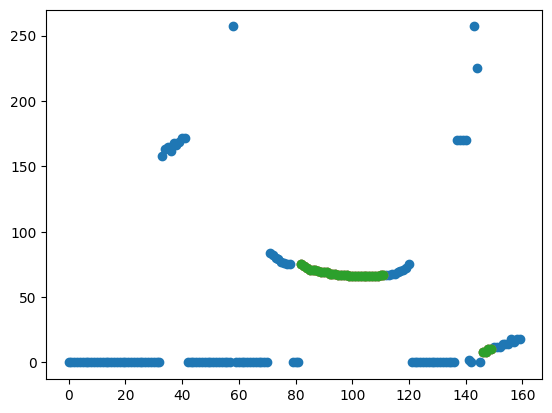

In [15]:
# importing matplotlib module
from matplotlib import pyplot as plt
import numpy as np

x = [i for i in range( len(distances) )]
y = [point["d"] for point in distances]
plt.scatter(x, y)

x = [point[0] for point in filteredDistances]
y = [point[1] for point in filteredDistances]
plt.scatter(x, y)
# print(f"X: {len(x)} / Y: {len(y)}")
 
# Function to plot scatter
plt.scatter(x, y)
 
# function to show the plot
plt.show()

# Done

In [2]:
device._board.close()

NameError: name 'device' is not defined